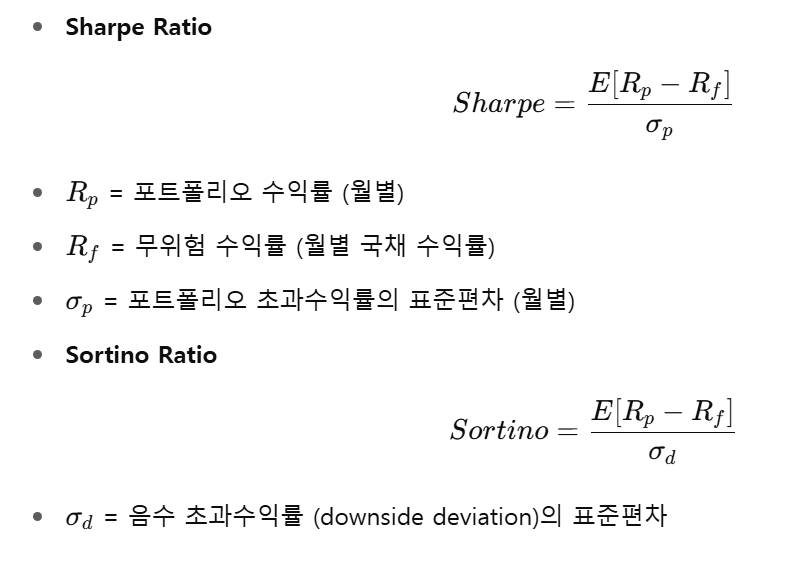

In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf

def load_portfolio_returns(portfolio_file, monthly_return_folder):
    portfolios = pd.read_csv(portfolio_file)
    etfs = portfolios.columns.tolist()
    etfs.remove('Portfolio ID')

    returns_list = []
    for etf in etfs:
        file_path = os.path.join(monthly_return_folder, f"{etf}_monthly_return.csv")
        df = pd.read_csv(file_path, parse_dates=['Date'])
        df.rename(columns={'Monthly Return': etf}, inplace=True)
        returns_list.append(df.set_index('Date'))

    returns_df = pd.concat(returns_list, axis=1)

    portfolio_returns = pd.DataFrame(index=returns_df.index)
    for idx, row in portfolios.iterrows():
        weights = row[1:]  # 'Portfolio ID' 제외한 비중
        portfolio_id = row['Portfolio ID']
        portfolio_returns[portfolio_id] = returns_df.mul(weights, axis=1).sum(axis=1)

    # 날짜를 컬럼으로 넣어 저장할 때 필요하므로 인덱스 리셋
    portfolio_returns = portfolio_returns.reset_index()
    return portfolio_returns

def download_and_clean_rf_rate(save_path="us_3m_treasury_rate_1998_2025_cleaned.csv"):
    ticker = "^IRX"
    start_date = "1998-02-01"
    end_date = "2025-05-31"

    irx = yf.Ticker(ticker)
    hist = irx.history(start=start_date, end=end_date)
    monthly_irx = hist['Close'].resample('ME').last() / 100  # % -> 소수 변환

    df_monthly_irx = monthly_irx.reset_index()
    df_monthly_irx.columns = ['Date', '3M_Treasury_Rate']

    # 시간대 제거
    df_monthly_irx['Date'] = pd.to_datetime(df_monthly_irx['Date'], utc=True)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.tz_convert(None)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.date

    df_monthly_irx.to_csv(save_path, index=False)
    print(f"무위험 수익률 데이터 저장 완료: {save_path}")
    return save_path

def calculate_ratios(portfolio_returns_file, rf_file, output_prefix):
    portfolio = pd.read_csv(portfolio_returns_file, parse_dates=['Date'])
    rf = pd.read_csv(rf_file)
    rf['Date'] = pd.to_datetime(rf['Date'], errors='coerce')

    if rf['Date'].dt.tz is not None:
        rf['Date'] = rf['Date'].dt.tz_localize(None)

    df = pd.merge(portfolio, rf, on='Date', how='inner')
    df['rf_monthly'] = df['3M_Treasury_Rate'] / 12

    portfolio_cols = [col for col in df.columns if col != 'Date' and col != '3M_Treasury_Rate' and col != 'rf_monthly']

    def sharpe_ratio(returns, rf_rate):
        mean_excess_return = (returns - rf_rate).mean()
        std_dev = (returns - rf_rate).std()
        if std_dev == 0:
            return np.nan
        return (mean_excess_return / std_dev) * np.sqrt(12)

    def sortino_ratio(returns, rf_rate):
        excess_returns = returns - rf_rate
        downside_std = excess_returns[excess_returns < 0].std()
        mean_excess_return = excess_returns.mean()
        if downside_std == 0:
            return np.nan
        return (mean_excess_return / downside_std) * np.sqrt(12)

    sharpe_list = []
    sortino_list = []

    for col in portfolio_cols:
        r = df[col]
        rf_rate = df['rf_monthly']
        sharpe_list.append(sharpe_ratio(r, rf_rate))
        sortino_list.append(sortino_ratio(r, rf_rate))

    results_df = pd.DataFrame({
        'Portfolio': portfolio_cols,
        'Sharpe Ratio': sharpe_list,
        'Sortino Ratio': sortino_list
    })

    results_df.to_csv(f'{output_prefix}_ratios.csv', index=False)
    print(f"{output_prefix}_ratios.csv 저장 완료")


if __name__ == "__main__":
    monthly_return_folder = 'monthly_return'

    # 1) 무위험 수익률 데이터 다운로드 및 저장 (처음 1회만 실행하면 됨)
    rf_file = download_and_clean_rf_rate()

    # 2) aggressive portfolios 처리
    aggressive_returns = load_portfolio_returns('aggressive_portfolios.csv', monthly_return_folder)
    aggressive_returns.to_csv('aggressive_portfolio_returns.csv', index=False, encoding='utf-8-sig')
    calculate_ratios('aggressive_portfolio_returns.csv', rf_file, 'aggressive_portfolios')

    # 3) defensive portfolios 처리
    defensive_returns = load_portfolio_returns('defensive_portfolios.csv', monthly_return_folder)
    defensive_returns.to_csv('defensive_portfolio_returns.csv', index=False, encoding='utf-8-sig')
    calculate_ratios('defensive_portfolio_returns.csv', rf_file, 'defensive_portfolios')

무위험 수익률 데이터 저장 완료: us_3m_treasury_rate_1998_2025_cleaned.csv
aggressive_portfolios_ratios.csv 저장 완료
defensive_portfolios_ratios.csv 저장 완료


In [2]:
import pandas as pd
import numpy as np

# CSV 파일 불러오기
agg_df = pd.read_csv('aggressive_portfolio_returns.csv', parse_dates=['Date'])
def_df = pd.read_csv('defensive_portfolio_returns.csv', parse_dates=['Date'])

# Date 컬럼 제외한 포트폴리오 컬럼 리스트
agg_portfolios = [col for col in agg_df.columns if col != 'Date']
def_portfolios = [col for col in def_df.columns if col != 'Date']

def calc_annualized_metrics(df, portfolios):
    T = len(df)  # 전체 월 개수
    results = []

    for p in portfolios:
        returns = df[p].values

        # 연환산 수익률 계산
        total_return = np.prod(1 + returns)
        ann_return = total_return ** (12 / T) - 1

        # 연환산 변동성 계산 (월별 표준편차 * sqrt(12))
        ann_volatility = np.std(returns, ddof=1) * np.sqrt(12)

        results.append({
            'Portfolio': p,
            'Annualized Return': ann_return,
            'Annualized Volatility': ann_volatility
        })

    return pd.DataFrame(results)

# Aggressive 포트폴리오 연 수익률, 변동성
agg_metrics = calc_annualized_metrics(agg_df, agg_portfolios)

# Defensive 포트폴리오 연 수익률, 변동성
def_metrics = calc_annualized_metrics(def_df, def_portfolios)

print("Aggressive Portfolio Metrics:")
print(agg_metrics.head())

print("\nDefensive Portfolio Metrics:")
print(def_metrics.head())

# 필요시 CSV 저장
agg_metrics.to_csv('aggressive_portfolio_annual_metrics.csv', index=False)
def_metrics.to_csv('defensive_portfolio_annual_metrics.csv', index=False)

Aggressive Portfolio Metrics:
      Portfolio  Annualized Return  Annualized Volatility
0  Aggressive_1           0.078638               0.104185
1  Aggressive_2           0.077004               0.121135
2  Aggressive_3           0.084179               0.117119
3  Aggressive_4           0.078638               0.104185
4  Aggressive_5           0.078638               0.104185

Defensive Portfolio Metrics:
     Portfolio  Annualized Return  Annualized Volatility
0  Defensive_1           0.082225               0.111824
1  Defensive_2           0.072992               0.109233
2  Defensive_3           0.066058               0.077413
3  Defensive_4           0.072992               0.109233
4  Defensive_5           0.081155               0.107642


In [3]:
import pandas as pd
import numpy as np

# 1. 연 수익률, 변동성 계산 함수 (앞에서 작성한 함수)
def calc_annualized_metrics(df, portfolios):
    T = len(df)  # 전체 월 개수
    results = []

    for p in portfolios:
        returns = df[p].values
        total_return = np.prod(1 + returns)
        ann_return = total_return ** (12 / T) - 1
        ann_volatility = np.std(returns, ddof=1) * np.sqrt(12)

        results.append({
            'Portfolio': p,
            'Annualized Return': ann_return,
            'Annualized Volatility': ann_volatility
        })

    return pd.DataFrame(results)

# 2. CSV 불러오기
agg_df = pd.read_csv('aggressive_portfolio_returns.csv', parse_dates=['Date'])
def_df = pd.read_csv('defensive_portfolio_returns.csv', parse_dates=['Date'])

agg_ratios = pd.read_csv('aggressive_portfolios_ratios.csv')
def_ratios = pd.read_csv('defensive_portfolios_ratios.csv')

# 3. 포트폴리오 리스트
agg_portfolios = [col for col in agg_df.columns if col != 'Date']
def_portfolios = [col for col in def_df.columns if col != 'Date']

# 4. 연 수익률, 변동성 계산
agg_metrics = calc_annualized_metrics(agg_df, agg_portfolios)
def_metrics = calc_annualized_metrics(def_df, def_portfolios)

# 5. ratios 데이터와 병합 (Portfolio 기준)
agg_full = pd.merge(agg_metrics, agg_ratios, on='Portfolio', how='left')
def_full = pd.merge(def_metrics, def_ratios, on='Portfolio', how='left')

# 6. 결과 확인
print("Aggressive Portfolio Combined Metrics:")
print(agg_full.head())

print("\nDefensive Portfolio Combined Metrics:")
print(def_full.head())

# 7. 파일 저장
agg_full.to_csv('aggressive_portfolio_full_metrics.csv', index=False)
def_full.to_csv('defensive_portfolio_full_metrics.csv', index=False)

Aggressive Portfolio Combined Metrics:
      Portfolio  Annualized Return  Annualized Volatility  Sharpe Ratio  \
0  Aggressive_1           0.078638               0.104185      0.584482   
1  Aggressive_2           0.077004               0.121135      0.505814   
2  Aggressive_3           0.084179               0.117119      0.576850   
3  Aggressive_4           0.078638               0.104185      0.584482   
4  Aggressive_5           0.078638               0.104185      0.584482   

   Sortino Ratio  
0       0.839382  
1       0.707674  
2       0.814938  
3       0.839382  
4       0.839382  

Defensive Portfolio Combined Metrics:
     Portfolio  Annualized Return  Annualized Volatility  Sharpe Ratio  \
0  Defensive_1           0.082225               0.111824      0.582077   
1  Defensive_2           0.072992               0.109233      0.513672   
2  Defensive_3           0.066058               0.077413      0.602671   
3  Defensive_4           0.072992               0.109233     

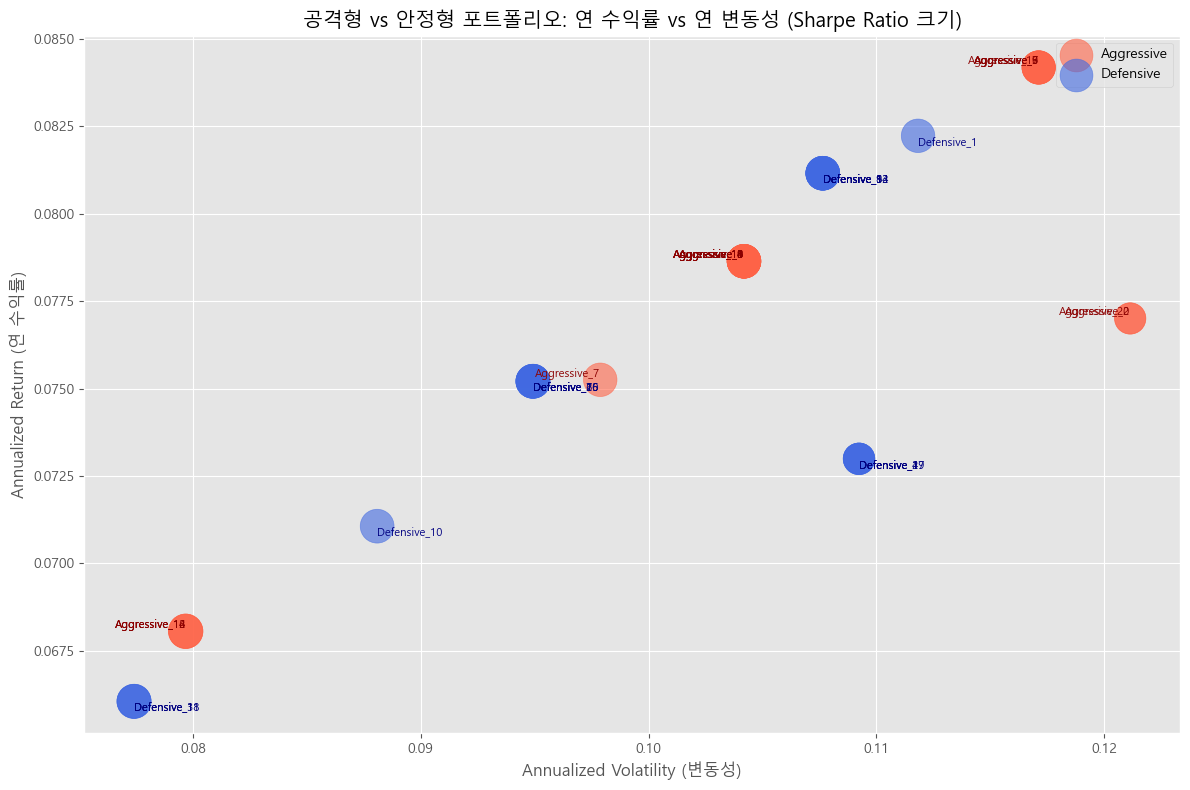

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows 사용자용)
mpl.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False


# CSV 파일 불러오기
aggressive_df = pd.read_csv('aggressive_portfolio_full_metrics.csv')
defensive_df = pd.read_csv('defensive_portfolio_full_metrics.csv')

# 스타일 지정
plt.style.use('ggplot')

# 버블 크기 조정 (Sharpe Ratio * 1000)
aggressive_df['BubbleSize'] = aggressive_df['Sharpe Ratio'] * 1000
defensive_df['BubbleSize'] = defensive_df['Sharpe Ratio'] * 1000

# 차트 크기
plt.figure(figsize=(12, 8))

# 공격형 버블 차트
plt.scatter(aggressive_df['Annualized Volatility'], aggressive_df['Annualized Return'],
            s=aggressive_df['BubbleSize'], alpha=0.6, c='tomato', label='Aggressive')

# 안정형 버블 차트
plt.scatter(defensive_df['Annualized Volatility'], defensive_df['Annualized Return'],
            s=defensive_df['BubbleSize'], alpha=0.6, c='royalblue', label='Defensive')

# 포트폴리오 이름 텍스트 추가 (공격형)
for _, row in aggressive_df.iterrows():
    plt.text(row['Annualized Volatility'], row['Annualized Return'], row['Portfolio'],
             fontsize=8, color='darkred', ha='right', va='bottom')

# 포트폴리오 이름 텍스트 추가 (안정형)
for _, row in defensive_df.iterrows():
    plt.text(row['Annualized Volatility'], row['Annualized Return'], row['Portfolio'],
             fontsize=8, color='navy', ha='left', va='top')

# 축 및 제목
plt.xlabel('Annualized Volatility (변동성)')
plt.ylabel('Annualized Return (연 수익률)')
plt.title('공격형 vs 안정형 포트폴리오: 연 수익률 vs 연 변동성 (Sharpe Ratio 크기)')

# 범례 및 그리드
plt.legend()
plt.grid(True)

# 시각화
plt.tight_layout()
plt.show()

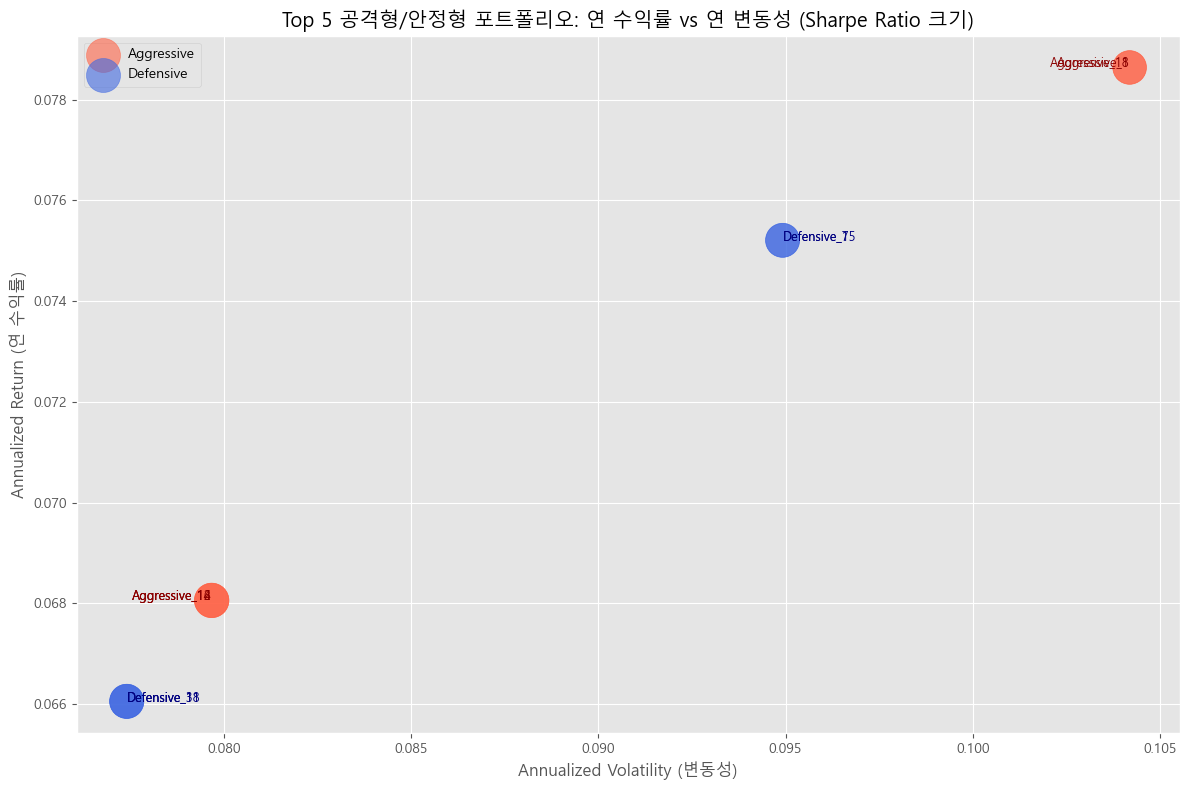

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows 사용자용)
mpl.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False


# CSV 파일 불러오기
aggressive_df = pd.read_csv('aggressive_portfolio_full_metrics.csv')
defensive_df = pd.read_csv('defensive_portfolio_full_metrics.csv')

# Sharpe Ratio 기준 Top 5 추출
top5_aggressive = aggressive_df.sort_values(by='Sharpe Ratio', ascending=False).head(5).copy()
top5_defensive = defensive_df.sort_values(by='Sharpe Ratio', ascending=False).head(5).copy()

# 버블 크기 조정 (Sharpe Ratio * 1000)
top5_aggressive['BubbleSize'] = top5_aggressive['Sharpe Ratio'] * 1000
top5_defensive['BubbleSize'] = top5_defensive['Sharpe Ratio'] * 1000

# 차트 크기
plt.figure(figsize=(12, 8))

# 버블 차트 그리기
plt.scatter(top5_aggressive['Annualized Volatility'], top5_aggressive['Annualized Return'],
            s=top5_aggressive['BubbleSize'], alpha=0.6, c='tomato', label='Aggressive')

plt.scatter(top5_defensive['Annualized Volatility'], top5_defensive['Annualized Return'],
            s=top5_defensive['BubbleSize'], alpha=0.6, c='royalblue', label='Defensive')

# 포트폴리오 이름 라벨 추가
for i, row in top5_aggressive.iterrows():
    plt.text(row['Annualized Volatility'], row['Annualized Return'], row['Portfolio'],
             fontsize=9, ha='right', color='darkred')
    
for i, row in top5_defensive.iterrows():
    plt.text(row['Annualized Volatility'], row['Annualized Return'], row['Portfolio'],
             fontsize=9, ha='left', color='navy')

# 각 축 라벨 및 제목
plt.xlabel('Annualized Volatility (변동성)')
plt.ylabel('Annualized Return (연 수익률)')
plt.title('Top 5 공격형/안정형 포트폴리오: 연 수익률 vs 연 변동성 (Sharpe Ratio 크기)')

# 범례
plt.legend()

# 그리드 추가
plt.grid(True)

# 시각화
plt.tight_layout()
plt.show()